In [1]:
from torchvision import transforms, datasets, utils
from sklearn.model_selection import KFold
from google.colab import drive

import copy
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [2]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/image-classification'

Mounted at /content/drive
/content/drive/My Drive/image-classification


In [3]:
params = {
  'legend.fontsize': 'x-large',
  'axes.labelsize': 'xx-large',
  'axes.titlesize': 'xx-large',
  'xtick.labelsize': 'x-large',
  'ytick.labelsize': 'x-large',
  'axes.titlepad': '20.0',
  'axes.labelpad': '20.0'}

pylab.rcParams.update(params)

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.ImageFolder(root='images', transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=48, shuffle=True)
all = dataset.samples

class_sizes = {}
category_sizes = {}
group_sizes = {}

for class_name in dataset.classes:
  class_size = len([x for x in dataset.samples if class_name in x[0]])
  class_sizes[class_name] = class_size

prohibitory = ['no_entry', 'no_stopping', 'speed_limit']
warning = ['caution_children', 'give_way', 'road_hump']
information = ['one_way_street', 'parking_area', 'pedestrian_crossing', 'priority_road', 'toucan_crossing']

category_sizes['prohibitory'] = sum([class_sizes[x] for x in prohibitory])
category_sizes['warning'] = sum([class_sizes[x] for x in warning])
category_sizes['information'] = sum([class_sizes[x] for x in information])

group1 = [x for x in dataset.samples if 'day' in x[0]]
group2 = [x for x in dataset.samples if 'night' in x[0]]
group3 = [x for x in dataset.samples if 'torch' in x[0]]

group_sizes['day'] = len(group1)
group_sizes['night'] = len(group2)
group_sizes['torch'] = len(group3)

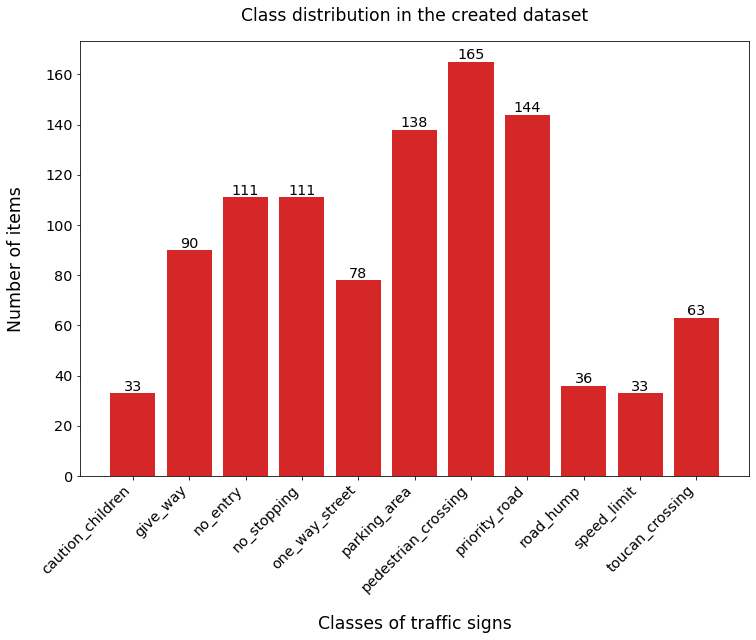

In [ ]:
x = list(class_sizes.keys())
y = list(class_sizes.values())

plt.figure(figsize=(12, 8))
plt.title('Class distribution in the created dataset')
plt.ylabel('Number of items')
plt.xlabel('Classes of traffic signs')
plt.xticks(rotation=45, ha='right')

for i in range(len(x)):
  plt.text(x=i, y=y[i] + 1.0, s=y[i], ha='center', fontsize='x-large')

plt.bar(x, y, color='tab:red')
plt.show()

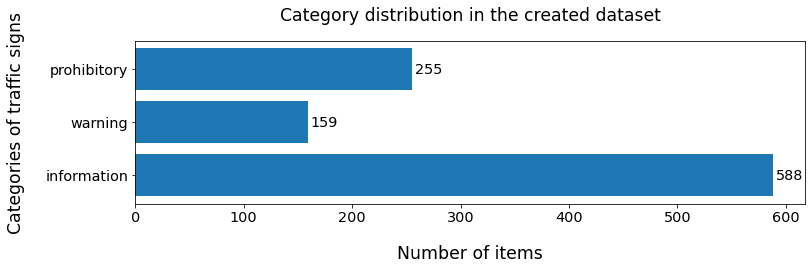

In [ ]:
x = list(category_sizes.keys())
y = list(category_sizes.values())

plt.figure(figsize=(12, 3))
plt.title('Category distribution in the created dataset')
plt.xlabel('Number of items')
plt.ylabel('Categories of traffic signs')

for i in range(len(x)):
  plt.text(x=y[i] + 3.0, y=i, s=y[i], va='center', fontsize='x-large')

plt.barh(x, y, color='tab:blue')
plt.gca().invert_yaxis()
plt.show()

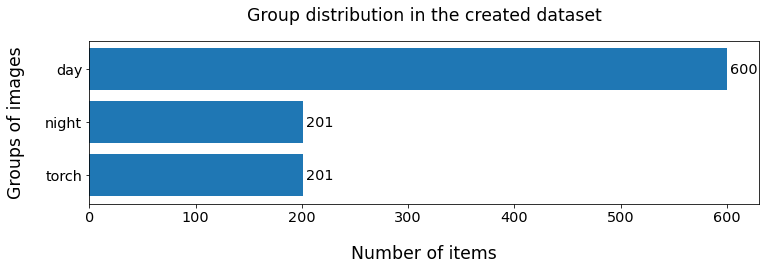

In [ ]:
x = list(group_sizes.keys())
y = list(group_sizes.values())

plt.figure(figsize=(12, 3))
plt.title('Group distribution in the created dataset')
plt.xlabel('Number of items')
plt.ylabel('Groups of images')

for i in range(len(x)):
  plt.text(x=y[i] + 3.0, y=i, s=y[i], va='center', fontsize='x-large')

plt.barh(x, y, color='tab:blue')
plt.gca().invert_yaxis()
plt.show()

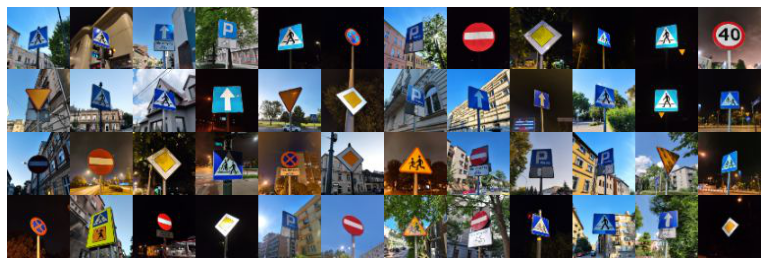

In [ ]:
dataset.samples = all
batch = next(iter(data_loader))
grid = utils.make_grid(batch[0], nrow=12, padding=0)

plt.figure(figsize=(13.5, 13.5))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

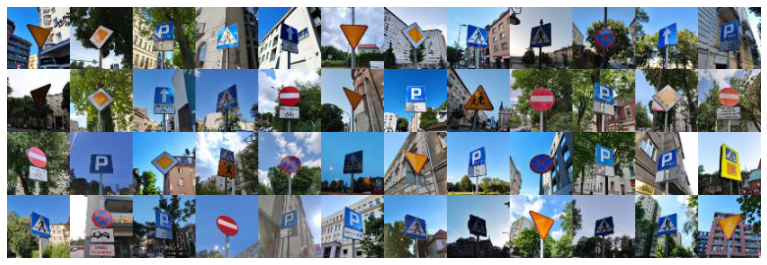

In [ ]:
dataset.samples = group1
batch = next(iter(data_loader))
grid = utils.make_grid(batch[0], nrow=12, padding=0)

plt.figure(figsize=(13.5, 13.5))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

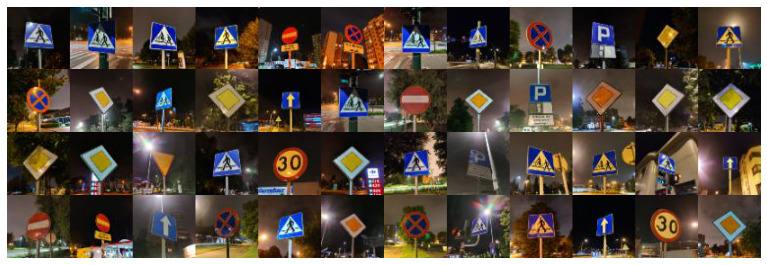

In [ ]:
dataset.samples = group2
batch = next(iter(data_loader))
grid = utils.make_grid(batch[0], nrow=12, padding=0)

plt.figure(figsize=(13.5, 13.5))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

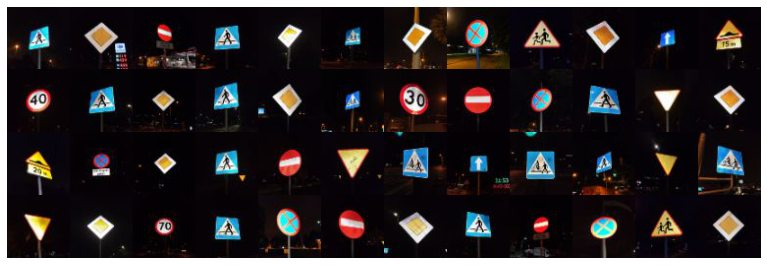

In [ ]:
dataset.samples = group3
batch = next(iter(data_loader))
grid = utils.make_grid(batch[0], nrow=12, padding=0)

plt.figure(figsize=(13.5, 13.5))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
def train_model(model, train_loader, device, criterion, optimizer):
  model.train()
  accumulator = 0

  for batch, (inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    accumulator += loss.item()
  
  return accumulator / len(train_loader)

In [ ]:
def eval_model(model, data_loader, device):
  model.eval()
  correct = 0
  total = 0

  for batch, (inputs, labels) in enumerate(data_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)
  
  return 100 * correct / total

In [ ]:
dataset.samples = all
cross_set, test_set = torch.utils.data.random_split(dataset, [668, 334])
kfold = KFold(n_splits=5, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
learning_rate = 0.001
batch_size = 16
epochs = 50
criterion = nn.NLLLoss()

In [ ]:
class Introduction1(nn.Module):
  def __init__(self):
    super(Introduction1, self).__init__()

    # input: 64 -> 20 -> 10
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=3, padding=2),
      nn.ReLU(),
      nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 10 -> 10 -> 5
    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
      nn.ReLU(),
      nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 5 -> 5
    self.layer3 = nn.Sequential(
      nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    # input: 5 -> 5
    self.layer4 = nn.Sequential(
      nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    # input: 5 -> 5 -> 2
    self.layer5 = nn.Sequential(
      nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2))
    
    self.layer6 = nn.Sequential(
      nn.Dropout(),
      nn.Linear(in_features=256*2*2, out_features=4096),
      nn.ReLU())
    
    self.layer7 = nn.Sequential(
      nn.Dropout(),
      nn.Linear(in_features=4096, out_features=4096),
      nn.ReLU())
    
    self.layer8 = nn.Linear(in_features=4096, out_features=11)
  
  def forward(self, x):
    acc = self.layer1(x)
    acc = self.layer2(acc)
    acc = self.layer3(acc)
    acc = self.layer4(acc)
    acc = self.layer5(acc)
    acc = acc.reshape(acc.size(0), -1)
    acc = self.layer6(acc)
    acc = self.layer7(acc)
    acc = self.layer8(acc)
    return nn.functional.log_softmax(acc, dim=-1)

In [ ]:
model_val_accuracy = np.zeros(epochs)

for selection, (train_index, val_index) in enumerate(kfold.split(cross_set)):
  model = Introduction1()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_set = torch.utils.data.Subset(dataset, train_index)
  val_set = torch.utils.data.Subset(dataset, val_index)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True)

  for epoch in range(epochs):
    loss_value = train_model(model, train_loader, device, criterion, optimizer)
    val_accuracy = eval_model(model, val_loader, device)
    model_val_accuracy[epoch] += val_accuracy

    if epoch % 10 == 9:
      print('Selection {}, Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(selection + 1, epoch + 1, loss_value, val_accuracy))
  
  print('')

introduction1_val_accuracy = np.divide(model_val_accuracy, kfold.n_splits)
print('Introduction1 validation accuracy: {:.2f}%'.format(max(introduction1_val_accuracy)))

Selection 1, Epoch 10, Loss: 1.19, Accuracy: 58.21%
Selection 1, Epoch 20, Loss: 0.60, Accuracy: 64.18%
Selection 1, Epoch 30, Loss: 0.39, Accuracy: 66.42%
Selection 1, Epoch 40, Loss: 0.25, Accuracy: 72.39%
Selection 1, Epoch 50, Loss: 0.21, Accuracy: 73.13%

Selection 2, Epoch 10, Loss: 1.15, Accuracy: 61.94%
Selection 2, Epoch 20, Loss: 0.69, Accuracy: 67.91%
Selection 2, Epoch 30, Loss: 0.34, Accuracy: 73.88%
Selection 2, Epoch 40, Loss: 0.25, Accuracy: 82.84%
Selection 2, Epoch 50, Loss: 0.53, Accuracy: 85.82%

Selection 3, Epoch 10, Loss: 1.19, Accuracy: 41.04%
Selection 3, Epoch 20, Loss: 0.59, Accuracy: 64.18%
Selection 3, Epoch 30, Loss: 0.46, Accuracy: 61.19%
Selection 3, Epoch 40, Loss: 0.22, Accuracy: 74.63%
Selection 3, Epoch 50, Loss: 0.17, Accuracy: 79.85%

Selection 4, Epoch 10, Loss: 1.84, Accuracy: 33.83%
Selection 4, Epoch 20, Loss: 0.71, Accuracy: 58.65%
Selection 4, Epoch 30, Loss: 0.44, Accuracy: 71.43%
Selection 4, Epoch 40, Loss: 0.14, Accuracy: 82.71%
Selection

In [ ]:
model_test_accuracy = np.zeros(epochs)

model = Introduction1()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cross_loader = torch.utils.data.DataLoader(cross_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(epochs):
  loss_value = train_model(model, cross_loader, device, criterion, optimizer)
  test_accuracy = eval_model(model, test_loader, device)
  model_test_accuracy[epoch] = test_accuracy

  if epoch % 10 == 9:
    print('Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(epoch + 1, loss_value, test_accuracy))

print('')

introduction1_test_accuracy = model_test_accuracy
print('Introduction1 test accuracy: {:.2f}%'.format(max(introduction1_test_accuracy)))

Epoch 10, Loss: 1.44, Accuracy: 44.61%
Epoch 20, Loss: 0.82, Accuracy: 60.78%
Epoch 30, Loss: 0.56, Accuracy: 64.67%
Epoch 40, Loss: 0.17, Accuracy: 71.86%
Epoch 50, Loss: 0.20, Accuracy: 75.75%

Introduction1 test accuracy: 75.75%


In [ ]:
class Introduction2(nn.Module):
  def __init__(self):
    super(Introduction2, self).__init__()

    # input: 64 -> 20 -> 10
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=48, kernel_size=11, stride=3, padding=2),
      nn.ReLU(),
      nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 10 -> 10 -> 5
    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels=48, out_channels=128, kernel_size=5, stride=1, padding=2),
      nn.ReLU(),
      nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 5 -> 5
    self.layer3 = nn.Sequential(
      nn.Conv2d(in_channels=128, out_channels=192, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    # input: 5 -> 5
    self.layer4 = nn.Sequential(
      nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    # input: 5 -> 5 -> 2
    self.layer5 = nn.Sequential(
      nn.Conv2d(in_channels=192, out_channels=128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2))
    
    self.layer6 = nn.Sequential(
      nn.Dropout(),
      nn.Linear(in_features=128*2*2, out_features=2048),
      nn.ReLU())
    
    self.layer7 = nn.Sequential(
      nn.Dropout(),
      nn.Linear(in_features=2048, out_features=2048),
      nn.ReLU())
    
    self.layer8 = nn.Linear(in_features=2048, out_features=11)
  
  def forward(self, x):
    acc = self.layer1(x)
    acc = self.layer2(acc)
    acc = self.layer3(acc)
    acc = self.layer4(acc)
    acc = self.layer5(acc)
    acc = acc.reshape(acc.size(0), -1)
    acc = self.layer6(acc)
    acc = self.layer7(acc)
    acc = self.layer8(acc)
    return nn.functional.log_softmax(acc, dim=-1)

In [ ]:
model_val_accuracy = np.zeros(epochs)

for selection, (train_index, val_index) in enumerate(kfold.split(cross_set)):
  model = Introduction2()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_set = torch.utils.data.Subset(dataset, train_index)
  val_set = torch.utils.data.Subset(dataset, val_index)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True)

  for epoch in range(epochs):
    loss_value = train_model(model, train_loader, device, criterion, optimizer)
    val_accuracy = eval_model(model, val_loader, device)
    model_val_accuracy[epoch] += val_accuracy

    if epoch % 10 == 9:
      print('Selection {}, Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(selection + 1, epoch + 1, loss_value, val_accuracy))
  
  print('')

introduction2_val_accuracy = np.divide(model_val_accuracy, kfold.n_splits)
print('Introduction2 validation accuracy: {:.2f}%'.format(max(introduction2_val_accuracy)))

Selection 1, Epoch 10, Loss: 1.14, Accuracy: 33.58%
Selection 1, Epoch 20, Loss: 0.59, Accuracy: 64.93%
Selection 1, Epoch 30, Loss: 0.38, Accuracy: 66.42%
Selection 1, Epoch 40, Loss: 0.27, Accuracy: 70.15%
Selection 1, Epoch 50, Loss: 0.15, Accuracy: 70.90%

Selection 2, Epoch 10, Loss: 1.42, Accuracy: 46.27%
Selection 2, Epoch 20, Loss: 0.72, Accuracy: 70.15%
Selection 2, Epoch 30, Loss: 0.36, Accuracy: 82.09%
Selection 2, Epoch 40, Loss: 0.32, Accuracy: 85.82%
Selection 2, Epoch 50, Loss: 0.01, Accuracy: 90.30%

Selection 3, Epoch 10, Loss: 1.90, Accuracy: 25.37%
Selection 3, Epoch 20, Loss: 1.03, Accuracy: 52.24%
Selection 3, Epoch 30, Loss: 0.60, Accuracy: 69.40%
Selection 3, Epoch 40, Loss: 0.50, Accuracy: 74.63%
Selection 3, Epoch 50, Loss: 0.31, Accuracy: 73.13%

Selection 4, Epoch 10, Loss: 1.91, Accuracy: 22.56%
Selection 4, Epoch 20, Loss: 0.75, Accuracy: 70.68%
Selection 4, Epoch 30, Loss: 0.48, Accuracy: 72.93%
Selection 4, Epoch 40, Loss: 0.21, Accuracy: 78.20%
Selection

In [ ]:
model_test_accuracy = np.zeros(epochs)

model = Introduction2()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cross_loader = torch.utils.data.DataLoader(cross_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(epochs):
  loss_value = train_model(model, cross_loader, device, criterion, optimizer)
  test_accuracy = eval_model(model, test_loader, device)
  model_test_accuracy[epoch] = test_accuracy

  if epoch % 10 == 9:
    print('Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(epoch + 1, loss_value, test_accuracy))

print('')

introduction2_test_accuracy = model_test_accuracy
print('Introduction2 test accuracy: {:.2f}%'.format(max(introduction2_test_accuracy)))

Epoch 10, Loss: 1.27, Accuracy: 46.71%
Epoch 20, Loss: 0.68, Accuracy: 61.98%
Epoch 30, Loss: 0.20, Accuracy: 81.74%
Epoch 40, Loss: 0.08, Accuracy: 83.23%
Epoch 50, Loss: 0.06, Accuracy: 82.93%

Introduction2 test accuracy: 86.53%


In [ ]:
class Introduction3(nn.Module):
  def __init__(self):
    super(Introduction3, self).__init__()

    # input: 64 -> 20 -> 10
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=24, kernel_size=11, stride=3, padding=2),
      nn.ReLU(),
      nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 10 -> 10 -> 5
    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels=24, out_channels=64, kernel_size=5, stride=1, padding=2),
      nn.ReLU(),
      nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 5 -> 5
    self.layer3 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    # input: 5 -> 5
    self.layer4 = nn.Sequential(
      nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    # input: 5 -> 5 -> 2
    self.layer5 = nn.Sequential(
      nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2))
    
    self.layer6 = nn.Sequential(
      nn.Dropout(),
      nn.Linear(in_features=64*2*2, out_features=1024),
      nn.ReLU())
    
    self.layer7 = nn.Sequential(
      nn.Dropout(),
      nn.Linear(in_features=1024, out_features=1024),
      nn.ReLU())
    
    self.layer8 = nn.Linear(in_features=1024, out_features=11)
  
  def forward(self, x):
    acc = self.layer1(x)
    acc = self.layer2(acc)
    acc = self.layer3(acc)
    acc = self.layer4(acc)
    acc = self.layer5(acc)
    acc = acc.reshape(acc.size(0), -1)
    acc = self.layer6(acc)
    acc = self.layer7(acc)
    acc = self.layer8(acc)
    return nn.functional.log_softmax(acc, dim=-1)

In [ ]:
model_val_accuracy = np.zeros(epochs)

for selection, (train_index, val_index) in enumerate(kfold.split(cross_set)):
  model = Introduction3()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_set = torch.utils.data.Subset(dataset, train_index)
  val_set = torch.utils.data.Subset(dataset, val_index)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True)

  for epoch in range(epochs):
    loss_value = train_model(model, train_loader, device, criterion, optimizer)
    val_accuracy = eval_model(model, val_loader, device)
    model_val_accuracy[epoch] += val_accuracy

    if epoch % 10 == 9:
      print('Selection {}, Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(selection + 1, epoch + 1, loss_value, val_accuracy))
  
  print('')

introduction3_val_accuracy = np.divide(model_val_accuracy, kfold.n_splits)
print('Introduction3 validation accuracy: {:.2f}%'.format(max(introduction3_val_accuracy)))

Selection 1, Epoch 10, Loss: 1.90, Accuracy: 17.16%
Selection 1, Epoch 20, Loss: 1.43, Accuracy: 44.03%
Selection 1, Epoch 30, Loss: 0.95, Accuracy: 52.24%
Selection 1, Epoch 40, Loss: 0.70, Accuracy: 59.70%
Selection 1, Epoch 50, Loss: 0.33, Accuracy: 73.88%

Selection 2, Epoch 10, Loss: 1.88, Accuracy: 17.16%
Selection 2, Epoch 20, Loss: 1.11, Accuracy: 50.75%
Selection 2, Epoch 30, Loss: 0.62, Accuracy: 64.93%
Selection 2, Epoch 40, Loss: 0.36, Accuracy: 71.64%
Selection 2, Epoch 50, Loss: 0.17, Accuracy: 79.85%

Selection 3, Epoch 10, Loss: 1.90, Accuracy: 26.12%
Selection 3, Epoch 20, Loss: 0.98, Accuracy: 50.75%
Selection 3, Epoch 30, Loss: 0.47, Accuracy: 78.36%
Selection 3, Epoch 40, Loss: 0.14, Accuracy: 86.57%
Selection 3, Epoch 50, Loss: 0.09, Accuracy: 85.07%

Selection 4, Epoch 10, Loss: 1.31, Accuracy: 49.62%
Selection 4, Epoch 20, Loss: 0.93, Accuracy: 48.87%
Selection 4, Epoch 30, Loss: 0.55, Accuracy: 62.41%
Selection 4, Epoch 40, Loss: 0.25, Accuracy: 67.67%
Selection

In [ ]:
model_test_accuracy = np.zeros(epochs)

model = Introduction3()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cross_loader = torch.utils.data.DataLoader(cross_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(epochs):
  loss_value = train_model(model, cross_loader, device, criterion, optimizer)
  test_accuracy = eval_model(model, test_loader, device)
  model_test_accuracy[epoch] = test_accuracy

  if epoch % 10 == 9:
    print('Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(epoch + 1, loss_value, test_accuracy))

print('')

introduction3_test_accuracy = model_test_accuracy
print('Introduction3 test accuracy: {:.2f}%'.format(max(introduction3_test_accuracy)))

Epoch 10, Loss: 1.26, Accuracy: 50.30%
Epoch 20, Loss: 0.45, Accuracy: 73.05%
Epoch 30, Loss: 0.18, Accuracy: 84.73%
Epoch 40, Loss: 0.05, Accuracy: 86.23%
Epoch 50, Loss: 0.05, Accuracy: 87.13%

Introduction3 test accuracy: 87.13%


In [ ]:
class Introduction4(nn.Module):
  def __init__(self):
    super(Introduction4, self).__init__()

    # input: 64 -> 20 -> 10
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=12, kernel_size=11, stride=3, padding=2),
      nn.ReLU(),
      nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 10 -> 10 -> 5
    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels=12, out_channels=32, kernel_size=5, stride=1, padding=2),
      nn.ReLU(),
      nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 5 -> 5
    self.layer3 = nn.Sequential(
      nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    # input: 5 -> 5
    self.layer4 = nn.Sequential(
      nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    # input: 5 -> 5 -> 2
    self.layer5 = nn.Sequential(
      nn.Conv2d(in_channels=48, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2))
    
    self.layer6 = nn.Sequential(
      nn.Dropout(),
      nn.Linear(in_features=32*2*2, out_features=512),
      nn.ReLU())
    
    self.layer7 = nn.Sequential(
      nn.Dropout(),
      nn.Linear(in_features=512, out_features=512),
      nn.ReLU())
    
    self.layer8 = nn.Linear(in_features=512, out_features=11)
  
  def forward(self, x):
    acc = self.layer1(x)
    acc = self.layer2(acc)
    acc = self.layer3(acc)
    acc = self.layer4(acc)
    acc = self.layer5(acc)
    acc = acc.reshape(acc.size(0), -1)
    acc = self.layer6(acc)
    acc = self.layer7(acc)
    acc = self.layer8(acc)
    return nn.functional.log_softmax(acc, dim=-1)

In [ ]:
model_val_accuracy = np.zeros(epochs)

for selection, (train_index, val_index) in enumerate(kfold.split(cross_set)):
  model = Introduction4()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_set = torch.utils.data.Subset(dataset, train_index)
  val_set = torch.utils.data.Subset(dataset, val_index)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True)

  for epoch in range(epochs):
    loss_value = train_model(model, train_loader, device, criterion, optimizer)
    val_accuracy = eval_model(model, val_loader, device)
    model_val_accuracy[epoch] += val_accuracy

    if epoch % 10 == 9:
      print('Selection {}, Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(selection + 1, epoch + 1, loss_value, val_accuracy))
  
  print('')

introduction4_val_accuracy = np.divide(model_val_accuracy, kfold.n_splits)
print('Introduction4 validation accuracy: {:.2f}%'.format(max(introduction4_val_accuracy)))

Selection 1, Epoch 10, Loss: 1.82, Accuracy: 32.09%
Selection 1, Epoch 20, Loss: 0.79, Accuracy: 55.22%
Selection 1, Epoch 30, Loss: 0.44, Accuracy: 66.42%
Selection 1, Epoch 40, Loss: 0.18, Accuracy: 76.12%
Selection 1, Epoch 50, Loss: 0.28, Accuracy: 71.64%

Selection 2, Epoch 10, Loss: 1.74, Accuracy: 26.87%
Selection 2, Epoch 20, Loss: 1.12, Accuracy: 44.78%
Selection 2, Epoch 30, Loss: 0.75, Accuracy: 60.45%
Selection 2, Epoch 40, Loss: 0.37, Accuracy: 73.13%
Selection 2, Epoch 50, Loss: 0.13, Accuracy: 73.13%

Selection 3, Epoch 10, Loss: 1.25, Accuracy: 44.03%
Selection 3, Epoch 20, Loss: 0.67, Accuracy: 68.66%
Selection 3, Epoch 30, Loss: 0.21, Accuracy: 77.61%
Selection 3, Epoch 40, Loss: 0.05, Accuracy: 88.06%
Selection 3, Epoch 50, Loss: 0.02, Accuracy: 85.82%

Selection 4, Epoch 10, Loss: 1.27, Accuracy: 48.87%
Selection 4, Epoch 20, Loss: 0.82, Accuracy: 54.14%
Selection 4, Epoch 30, Loss: 0.35, Accuracy: 81.20%
Selection 4, Epoch 40, Loss: 0.09, Accuracy: 90.23%
Selection

In [ ]:
model_test_accuracy = np.zeros(epochs)

model = Introduction4()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cross_loader = torch.utils.data.DataLoader(cross_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(epochs):
  loss_value = train_model(model, cross_loader, device, criterion, optimizer)
  test_accuracy = eval_model(model, test_loader, device)
  model_test_accuracy[epoch] = test_accuracy

  if epoch % 10 == 9:
    print('Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(epoch + 1, loss_value, test_accuracy))

print('')

introduction4_test_accuracy = model_test_accuracy
print('Introduction4 test accuracy: {:.2f}%'.format(max(introduction4_test_accuracy)))

Epoch 10, Loss: 1.79, Accuracy: 29.04%
Epoch 20, Loss: 1.48, Accuracy: 35.63%
Epoch 30, Loss: 1.14, Accuracy: 45.81%
Epoch 40, Loss: 0.80, Accuracy: 53.29%
Epoch 50, Loss: 0.53, Accuracy: 58.08%

Introduction4 test accuracy: 61.98%


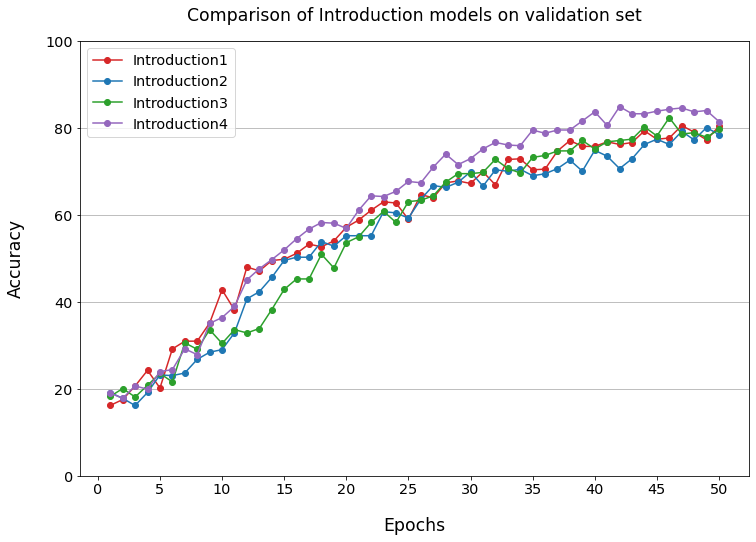

In [ ]:
x = list(range(1, epochs + 1))
y1 = introduction1_val_accuracy.tolist()
y2 = introduction2_val_accuracy.tolist()
y3 = introduction3_val_accuracy.tolist()
y4 = introduction4_val_accuracy.tolist()

plt.figure(figsize=(12, 8))
plt.title('Comparison of Introduction models on validation set')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(0, 100)
plt.xticks(np.arange(0, epochs + 1, step=epochs/10, dtype=int))

plt.plot(x, y1, marker='o', label='Introduction1', color='tab:red')
plt.plot(x, y2, marker='o', label='Introduction2', color='tab:blue')
plt.plot(x, y3, marker='o', label='Introduction3', color='tab:green')
plt.plot(x, y4, marker='o', label='Introduction4', color='tab:purple')
plt.grid(axis='y')
plt.legend(loc=2)
plt.show()

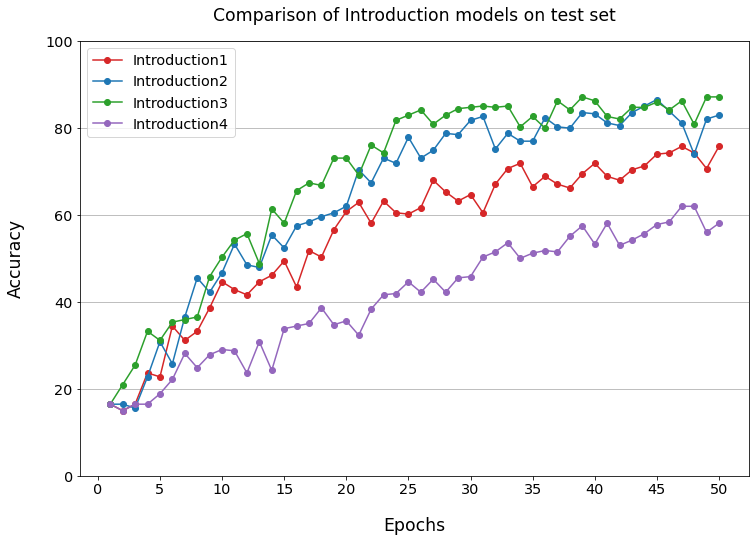

In [ ]:
x = list(range(1, epochs + 1))
y1 = introduction1_test_accuracy.tolist()
y2 = introduction2_test_accuracy.tolist()
y3 = introduction3_test_accuracy.tolist()
y4 = introduction4_test_accuracy.tolist()

plt.figure(figsize=(12, 8))
plt.title('Comparison of Introduction models on test set')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(0, 100)
plt.xticks(np.arange(0, epochs + 1, step=epochs/10, dtype=int))

plt.plot(x, y1, marker='o', label='Introduction1', color='tab:red')
plt.plot(x, y2, marker='o', label='Introduction2', color='tab:blue')
plt.plot(x, y3, marker='o', label='Introduction3', color='tab:green')
plt.plot(x, y4, marker='o', label='Introduction4', color='tab:purple')
plt.grid(axis='y')
plt.legend(loc=2)
plt.show()

In [ ]:
print('Introduction1 validation accuracy: {:.2f}%'.format(max(introduction1_val_accuracy)))
print('Introduction2 validation accuracy: {:.2f}%'.format(max(introduction2_val_accuracy)))
print('Introduction3 validation accuracy: {:.2f}%'.format(max(introduction3_val_accuracy)))
print('Introduction4 validation accuracy: {:.2f}%'.format(max(introduction4_val_accuracy)))
print('')

print('Introduction1 test accuracy: {:.2f}%'.format(max(introduction1_test_accuracy)))
print('Introduction2 test accuracy: {:.2f}%'.format(max(introduction2_test_accuracy)))
print('Introduction3 test accuracy: {:.2f}%'.format(max(introduction3_test_accuracy)))
print('Introduction4 test accuracy: {:.2f}%'.format(max(introduction4_test_accuracy)))

Introduction1 validation accuracy: 80.53%
Introduction2 validation accuracy: 80.09%
Introduction3 validation accuracy: 82.34%
Introduction4 validation accuracy: 84.89%

Introduction1 test accuracy: 75.75%
Introduction2 test accuracy: 86.53%
Introduction3 test accuracy: 87.13%
Introduction4 test accuracy: 61.98%


In [ ]:
class Modern1(nn.Module):
  def __init__(self):
    super(Modern1, self).__init__()

    # input: 64 -> 64 -> 32
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 32 -> 32 -> 16
    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 16 -> 16
    self.layer3 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    # input: 16 -> 16
    self.layer4 = nn.Sequential(
      nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    # input: 16 -> 16 -> 8
    self.layer5 = nn.Sequential(
      nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.layer6 = nn.Sequential(
      nn.Dropout(),
      nn.Linear(in_features=64*8*8, out_features=1024),
      nn.ReLU())
    
    self.layer7 = nn.Sequential(
      nn.Dropout(),
      nn.Linear(in_features=1024, out_features=1024),
      nn.ReLU())
    
    self.layer8 = nn.Linear(in_features=1024, out_features=11)
  
  def forward(self, x):
    acc = self.layer1(x)
    acc = self.layer2(acc)
    acc = self.layer3(acc)
    acc = self.layer4(acc)
    acc = self.layer5(acc)
    acc = acc.reshape(acc.size(0), -1)
    acc = self.layer6(acc)
    acc = self.layer7(acc)
    acc = self.layer8(acc)
    return nn.functional.log_softmax(acc, dim=-1)

In [ ]:
model_val_accuracy = np.zeros(epochs)

for selection, (train_index, val_index) in enumerate(kfold.split(cross_set)):
  model = Modern1()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_set = torch.utils.data.Subset(dataset, train_index)
  val_set = torch.utils.data.Subset(dataset, val_index)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True)

  for epoch in range(epochs):
    loss_value = train_model(model, train_loader, device, criterion, optimizer)
    val_accuracy = eval_model(model, val_loader, device)
    model_val_accuracy[epoch] += val_accuracy

    if epoch % 10 == 9:
      print('Selection {}, Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(selection + 1, epoch + 1, loss_value, val_accuracy))
  
  print('')

modern1_val_accuracy = np.divide(model_val_accuracy, kfold.n_splits)
print('Modern1 validation accuracy: {:.2f}%'.format(max(modern1_val_accuracy)))

Selection 1, Epoch 10, Loss: 1.15, Accuracy: 45.52%
Selection 1, Epoch 20, Loss: 0.20, Accuracy: 90.30%
Selection 1, Epoch 30, Loss: 0.05, Accuracy: 97.76%
Selection 1, Epoch 40, Loss: 0.09, Accuracy: 97.01%
Selection 1, Epoch 50, Loss: 0.01, Accuracy: 98.51%

Selection 2, Epoch 10, Loss: 1.90, Accuracy: 22.39%
Selection 2, Epoch 20, Loss: 1.63, Accuracy: 37.31%
Selection 2, Epoch 30, Loss: 0.64, Accuracy: 76.87%
Selection 2, Epoch 40, Loss: 0.12, Accuracy: 92.54%
Selection 2, Epoch 50, Loss: 0.10, Accuracy: 94.78%

Selection 3, Epoch 10, Loss: 1.90, Accuracy: 29.10%
Selection 3, Epoch 20, Loss: 0.43, Accuracy: 76.87%
Selection 3, Epoch 30, Loss: 0.17, Accuracy: 90.30%
Selection 3, Epoch 40, Loss: 0.09, Accuracy: 88.06%
Selection 3, Epoch 50, Loss: 0.07, Accuracy: 91.79%

Selection 4, Epoch 10, Loss: 1.16, Accuracy: 46.62%
Selection 4, Epoch 20, Loss: 0.17, Accuracy: 90.98%
Selection 4, Epoch 30, Loss: 0.04, Accuracy: 96.24%
Selection 4, Epoch 40, Loss: 0.00, Accuracy: 95.49%
Selection

In [ ]:
model_test_accuracy = np.zeros(epochs)

model = Modern1()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cross_loader = torch.utils.data.DataLoader(cross_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(epochs):
  loss_value = train_model(model, cross_loader, device, criterion, optimizer)
  test_accuracy = eval_model(model, test_loader, device)
  model_test_accuracy[epoch] = test_accuracy

  if epoch % 10 == 9:
    print('Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(epoch + 1, loss_value, test_accuracy))

print('')

modern1_test_accuracy = model_test_accuracy
print('Modern1 test accuracy: {:.2f}%'.format(max(modern1_test_accuracy)))

Epoch 10, Loss: 0.67, Accuracy: 71.86%
Epoch 20, Loss: 0.20, Accuracy: 82.93%
Epoch 30, Loss: 0.12, Accuracy: 82.04%
Epoch 40, Loss: 0.08, Accuracy: 85.33%
Epoch 50, Loss: 0.01, Accuracy: 90.72%

Modern1 test accuracy: 91.62%


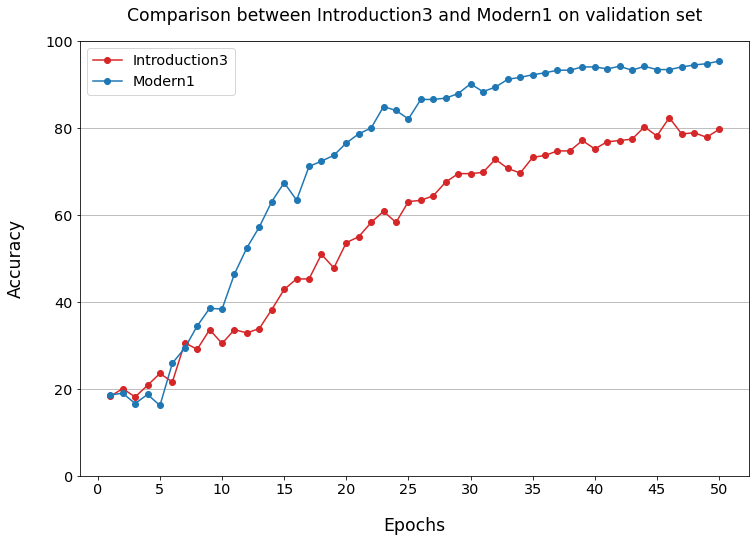

In [ ]:
x = list(range(1, epochs + 1))
y1 = introduction3_val_accuracy.tolist()
y2 = modern1_val_accuracy.tolist()

plt.figure(figsize=(12, 8))
plt.title('Comparison between Introduction3 and Modern1 on validation set')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(0, 100)
plt.xticks(np.arange(0, epochs + 1, step=epochs/10, dtype=int))

plt.plot(x, y1, marker='o', label='Introduction3', color='tab:red')
plt.plot(x, y2, marker='o', label='Modern1', color='tab:blue')
plt.grid(axis='y')
plt.legend(loc=2)
plt.show()

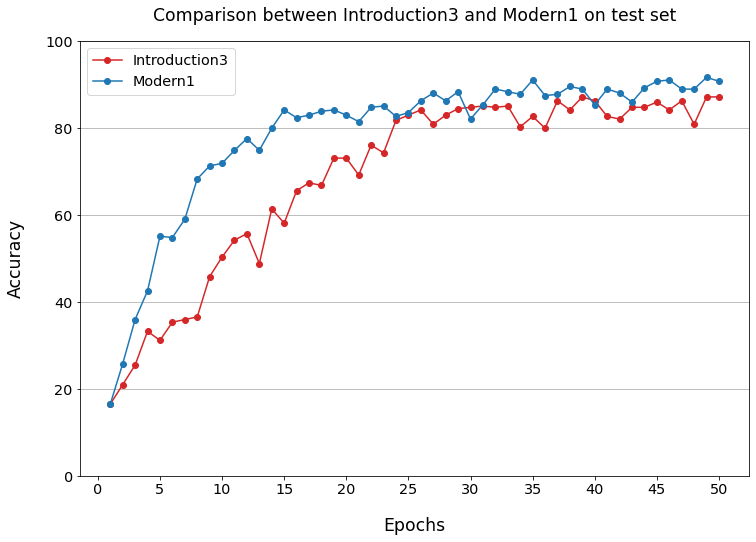

In [ ]:
x = list(range(1, epochs + 1))
y1 = introduction3_test_accuracy.tolist()
y2 = modern1_test_accuracy.tolist()

plt.figure(figsize=(12, 8))
plt.title('Comparison between Introduction3 and Modern1 on test set')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(0, 100)
plt.xticks(np.arange(0, epochs + 1, step=epochs/10, dtype=int))

plt.plot(x, y1, marker='o', label='Introduction3', color='tab:red')
plt.plot(x, y2, marker='o', label='Modern1', color='tab:blue')
plt.grid(axis='y')
plt.legend(loc=2)
plt.show()

In [ ]:
print('Introduction3 validation accuracy: {:.2f}%'.format(max(introduction3_val_accuracy)))
print('Modern1 validation accuracy: {:.2f}%'.format(max(modern1_val_accuracy)))
print('')

print('Introduction3 test accuracy: {:.2f}%'.format(max(introduction3_test_accuracy)))
print('Modern1 test accuracy: {:.2f}%'.format(max(modern1_test_accuracy)))

Introduction3 validation accuracy: 82.34%
Modern1 validation accuracy: 95.36%

Introduction3 test accuracy: 87.13%
Modern1 test accuracy: 91.62%


In [ ]:
class Modern2(nn.Module):
  def __init__(self):
    super(Modern2, self).__init__()

    # input: 64 -> 64 -> 32
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(num_features=24),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 32 -> 32 -> 16
    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(num_features=64),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 16 -> 16
    self.layer3 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    # input: 16 -> 16
    self.layer4 = nn.Sequential(
      nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    # input: 16 -> 16 -> 8
    self.layer5 = nn.Sequential(
      nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.layer6 = nn.Sequential(
      nn.Dropout(),
      nn.Linear(in_features=64*8*8, out_features=1024),
      nn.ReLU())
    
    self.layer7 = nn.Sequential(
      nn.Dropout(),
      nn.Linear(in_features=1024, out_features=1024),
      nn.ReLU())
    
    self.layer8 = nn.Linear(in_features=1024, out_features=11)
  
  def forward(self, x):
    acc = self.layer1(x)
    acc = self.layer2(acc)
    acc = self.layer3(acc)
    acc = self.layer4(acc)
    acc = self.layer5(acc)
    acc = acc.reshape(acc.size(0), -1)
    acc = self.layer6(acc)
    acc = self.layer7(acc)
    acc = self.layer8(acc)
    return nn.functional.log_softmax(acc, dim=-1)

In [ ]:
model_val_accuracy = np.zeros(epochs)

for selection, (train_index, val_index) in enumerate(kfold.split(cross_set)):
  model = Modern2()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_set = torch.utils.data.Subset(dataset, train_index)
  val_set = torch.utils.data.Subset(dataset, val_index)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True)

  for epoch in range(epochs):
    loss_value = train_model(model, train_loader, device, criterion, optimizer)
    val_accuracy = eval_model(model, val_loader, device)
    model_val_accuracy[epoch] += val_accuracy

    if epoch % 10 == 9:
      print('Selection {}, Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(selection + 1, epoch + 1, loss_value, val_accuracy))
  
  print('')

modern2_val_accuracy = np.divide(model_val_accuracy, kfold.n_splits)
print('Modern2 validation accuracy: {:.2f}%'.format(max(modern2_val_accuracy)))

Selection 1, Epoch 10, Loss: 0.10, Accuracy: 97.76%
Selection 1, Epoch 20, Loss: 0.06, Accuracy: 94.78%
Selection 1, Epoch 30, Loss: 0.02, Accuracy: 96.27%
Selection 1, Epoch 40, Loss: 0.00, Accuracy: 98.51%
Selection 1, Epoch 50, Loss: 0.00, Accuracy: 99.25%

Selection 2, Epoch 10, Loss: 0.15, Accuracy: 91.04%
Selection 2, Epoch 20, Loss: 0.07, Accuracy: 98.51%
Selection 2, Epoch 30, Loss: 0.04, Accuracy: 99.25%
Selection 2, Epoch 40, Loss: 0.14, Accuracy: 95.52%
Selection 2, Epoch 50, Loss: 0.00, Accuracy: 98.51%

Selection 3, Epoch 10, Loss: 0.12, Accuracy: 93.28%
Selection 3, Epoch 20, Loss: 0.04, Accuracy: 96.27%
Selection 3, Epoch 30, Loss: 0.00, Accuracy: 97.76%
Selection 3, Epoch 40, Loss: 0.12, Accuracy: 94.78%
Selection 3, Epoch 50, Loss: 0.22, Accuracy: 94.78%

Selection 4, Epoch 10, Loss: 0.02, Accuracy: 96.99%
Selection 4, Epoch 20, Loss: 0.04, Accuracy: 95.49%
Selection 4, Epoch 30, Loss: 0.10, Accuracy: 95.49%
Selection 4, Epoch 40, Loss: 0.16, Accuracy: 97.74%
Selection

In [ ]:
model_test_accuracy = np.zeros(epochs)

model = Modern2()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cross_loader = torch.utils.data.DataLoader(cross_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(epochs):
  loss_value = train_model(model, cross_loader, device, criterion, optimizer)
  test_accuracy = eval_model(model, test_loader, device)
  model_test_accuracy[epoch] = test_accuracy

  if epoch % 10 == 9:
    print('Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(epoch + 1, loss_value, test_accuracy))

print('')

modern2_test_accuracy = model_test_accuracy
print('Modern2 test accuracy: {:.2f}%'.format(max(modern2_test_accuracy)))

Epoch 10, Loss: 0.26, Accuracy: 86.83%
Epoch 20, Loss: 0.12, Accuracy: 89.82%
Epoch 30, Loss: 0.08, Accuracy: 94.61%
Epoch 40, Loss: 0.03, Accuracy: 95.51%
Epoch 50, Loss: 0.01, Accuracy: 95.51%

Modern2 test accuracy: 97.01%


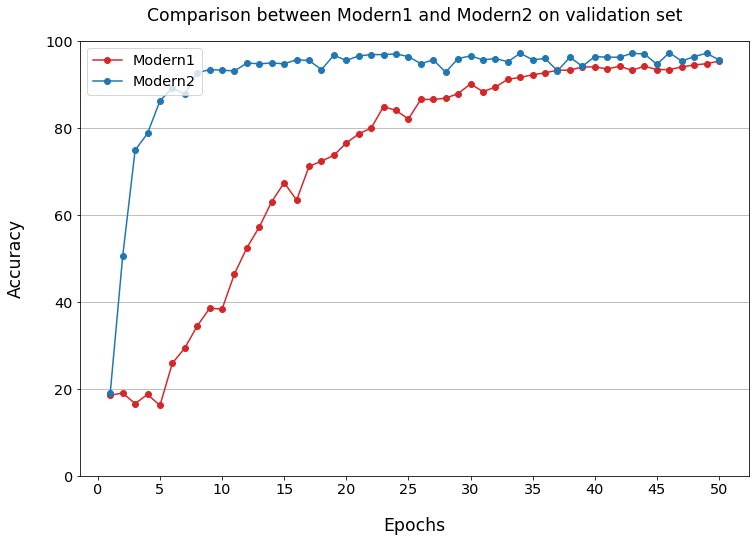

In [ ]:
x = list(range(1, epochs + 1))
y1 = modern1_val_accuracy.tolist()
y2 = modern2_val_accuracy.tolist()

plt.figure(figsize=(12, 8))
plt.title('Comparison between Modern1 and Modern2 on validation set')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(0, 100)
plt.xticks(np.arange(0, epochs + 1, step=epochs/10, dtype=int))

plt.plot(x, y1, marker='o', label='Modern1', color='tab:red')
plt.plot(x, y2, marker='o', label='Modern2', color='tab:blue')
plt.grid(axis='y')
plt.legend(loc=2)
plt.show()

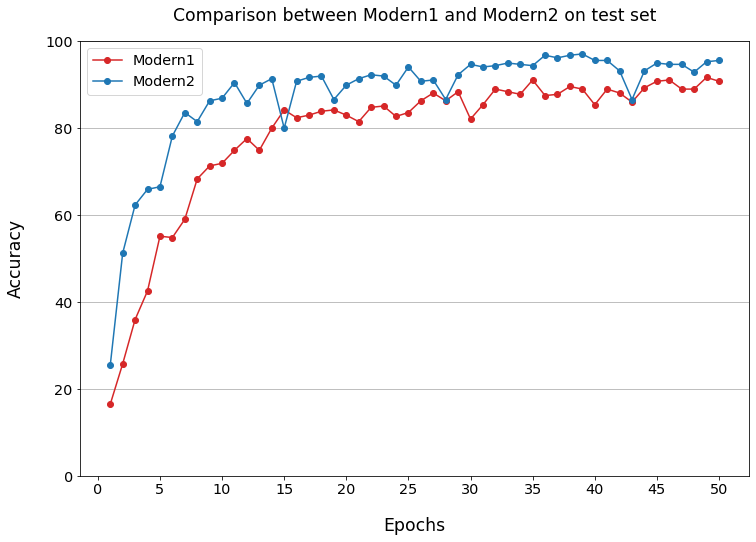

In [ ]:
x = list(range(1, epochs + 1))
y1 = modern1_test_accuracy.tolist()
y2 = modern2_test_accuracy.tolist()

plt.figure(figsize=(12, 8))
plt.title('Comparison between Modern1 and Modern2 on test set')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(0, 100)
plt.xticks(np.arange(0, epochs + 1, step=epochs/10, dtype=int))

plt.plot(x, y1, marker='o', label='Modern1', color='tab:red')
plt.plot(x, y2, marker='o', label='Modern2', color='tab:blue')
plt.grid(axis='y')
plt.legend(loc=2)
plt.show()

In [ ]:
print('Modern1 validation accuracy: {:.2f}%'.format(max(modern1_val_accuracy)))
print('Modern2 validation accuracy: {:.2f}%'.format(max(modern2_val_accuracy)))
print('')

print('Modern1 test accuracy: {:.2f}%'.format(max(modern1_test_accuracy)))
print('Modern2 test accuracy: {:.2f}%'.format(max(modern2_test_accuracy)))

Modern1 validation accuracy: 95.36%
Modern2 validation accuracy: 97.30%

Modern1 test accuracy: 91.62%
Modern2 test accuracy: 97.01%


In [ ]:
class Modern3(nn.Module):
  def __init__(self):
    super(Modern3, self).__init__()

    # input: 64 -> 64 -> 32
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(num_features=24),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 32 -> 32 -> 16
    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(num_features=64),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 16 -> 16
    self.layer3 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    # input: 16 -> 16
    self.layer4 = nn.Sequential(
      nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    # input: 16 -> 16 -> 8
    self.layer5 = nn.Sequential(
      nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
    
    # input: 8 -> 8
    self.layer6 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=24, kernel_size=3, stride=1, padding=1),
      nn.ReLU())
    
    self.layer7 = nn.Sequential(
      nn.Dropout(),
      nn.Linear(in_features=24*8*8, out_features=11))
  
  def forward(self, x):
    acc = self.layer1(x)
    acc = self.layer2(acc)
    acc = self.layer3(acc)
    acc = self.layer4(acc)
    acc = self.layer5(acc)
    acc = self.layer6(acc)
    acc = acc.reshape(acc.size(0), -1)
    acc = self.layer7(acc)
    return nn.functional.log_softmax(acc, dim=-1)

In [ ]:
model_val_accuracy = np.zeros(epochs)

for selection, (train_index, val_index) in enumerate(kfold.split(cross_set)):
  model = Modern3()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_set = torch.utils.data.Subset(dataset, train_index)
  val_set = torch.utils.data.Subset(dataset, val_index)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True)

  for epoch in range(epochs):
    loss_value = train_model(model, train_loader, device, criterion, optimizer)
    val_accuracy = eval_model(model, val_loader, device)
    model_val_accuracy[epoch] += val_accuracy

    if epoch % 10 == 9:
      print('Selection {}, Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(selection + 1, epoch + 1, loss_value, val_accuracy))
  
  print('')

modern3_val_accuracy = np.divide(model_val_accuracy, kfold.n_splits)
print('Modern3 validation accuracy: {:.2f}%'.format(max(modern3_val_accuracy)))

Selection 1, Epoch 10, Loss: 0.06, Accuracy: 97.01%
Selection 1, Epoch 20, Loss: 0.06, Accuracy: 96.27%
Selection 1, Epoch 30, Loss: 0.01, Accuracy: 97.76%
Selection 1, Epoch 40, Loss: 0.01, Accuracy: 99.25%
Selection 1, Epoch 50, Loss: 0.00, Accuracy: 96.27%

Selection 2, Epoch 10, Loss: 0.09, Accuracy: 94.03%
Selection 2, Epoch 20, Loss: 0.04, Accuracy: 97.01%
Selection 2, Epoch 30, Loss: 0.04, Accuracy: 98.51%
Selection 2, Epoch 40, Loss: 0.19, Accuracy: 96.27%
Selection 2, Epoch 50, Loss: 0.00, Accuracy: 97.01%

Selection 3, Epoch 10, Loss: 0.09, Accuracy: 96.27%
Selection 3, Epoch 20, Loss: 0.06, Accuracy: 92.54%
Selection 3, Epoch 30, Loss: 0.08, Accuracy: 92.54%
Selection 3, Epoch 40, Loss: 0.00, Accuracy: 95.52%
Selection 3, Epoch 50, Loss: 0.00, Accuracy: 97.01%

Selection 4, Epoch 10, Loss: 0.14, Accuracy: 95.49%
Selection 4, Epoch 20, Loss: 0.02, Accuracy: 95.49%
Selection 4, Epoch 30, Loss: 0.02, Accuracy: 94.74%
Selection 4, Epoch 40, Loss: 0.02, Accuracy: 97.74%
Selection

In [ ]:
model_test_accuracy = np.zeros(epochs)

model = Modern3()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cross_loader = torch.utils.data.DataLoader(cross_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(epochs):
  loss_value = train_model(model, cross_loader, device, criterion, optimizer)
  test_accuracy = eval_model(model, test_loader, device)
  model_test_accuracy[epoch] = test_accuracy

  if epoch % 10 == 9:
    print('Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(epoch + 1, loss_value, test_accuracy))

print('')

modern3_test_accuracy = model_test_accuracy
print('Modern3 test accuracy: {:.2f}%'.format(max(modern3_test_accuracy)))

Epoch 10, Loss: 0.10, Accuracy: 91.32%
Epoch 20, Loss: 0.01, Accuracy: 94.31%
Epoch 30, Loss: 0.07, Accuracy: 94.01%
Epoch 40, Loss: 0.02, Accuracy: 98.20%
Epoch 50, Loss: 0.01, Accuracy: 95.81%

Modern3 test accuracy: 98.20%


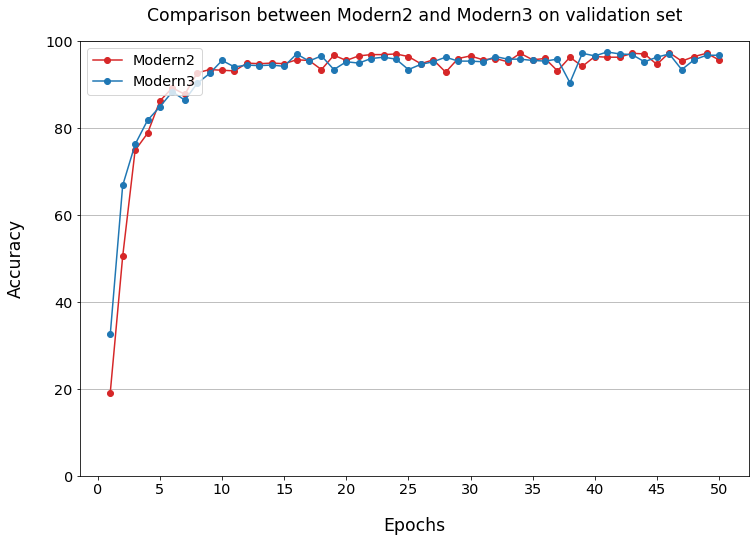

In [ ]:
x = list(range(1, epochs + 1))
y1 = modern2_val_accuracy.tolist()
y2 = modern3_val_accuracy.tolist()

plt.figure(figsize=(12, 8))
plt.title('Comparison between Modern2 and Modern3 on validation set')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(0, 100)
plt.xticks(np.arange(0, epochs + 1, step=epochs/10, dtype=int))

plt.plot(x, y1, marker='o', label='Modern2', color='tab:red')
plt.plot(x, y2, marker='o', label='Modern3', color='tab:blue')
plt.grid(axis='y')
plt.legend(loc=2)
plt.show()

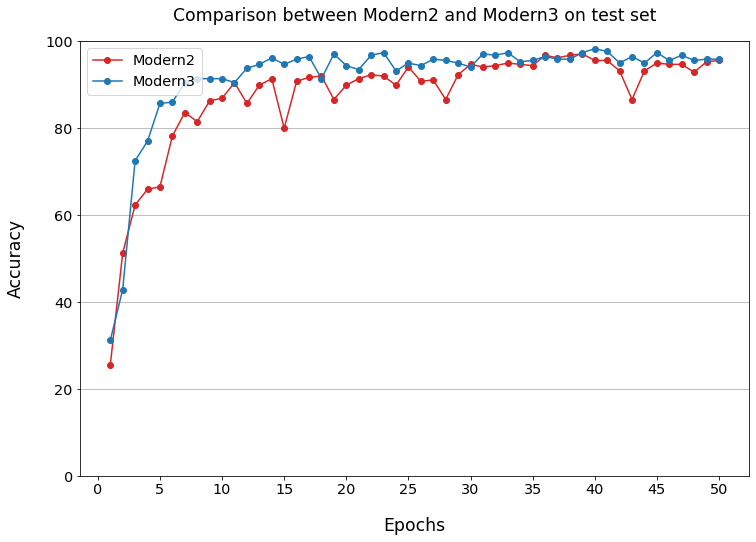

In [ ]:
x = list(range(1, epochs + 1))
y1 = modern2_test_accuracy.tolist()
y2 = modern3_test_accuracy.tolist()

plt.figure(figsize=(12, 8))
plt.title('Comparison between Modern2 and Modern3 on test set')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(0, 100)
plt.xticks(np.arange(0, epochs + 1, step=epochs/10, dtype=int))

plt.plot(x, y1, marker='o', label='Modern2', color='tab:red')
plt.plot(x, y2, marker='o', label='Modern3', color='tab:blue')
plt.grid(axis='y')
plt.legend(loc=2)
plt.show()

In [ ]:
print('Modern2 validation accuracy: {:.2f}%'.format(max(modern2_val_accuracy)))
print('Modern3 validation accuracy: {:.2f}%'.format(max(modern3_val_accuracy)))
print('')

print('Modern2 test accuracy: {:.2f}%'.format(max(modern2_test_accuracy)))
print('Modern3 test accuracy: {:.2f}%'.format(max(modern3_test_accuracy)))

Modern2 validation accuracy: 97.30%
Modern3 validation accuracy: 97.46%

Modern2 test accuracy: 97.01%
Modern3 test accuracy: 98.20%


In [ ]:
learning_rate = 0.001
batch_size = 16
epochs = 100
criterion = nn.NLLLoss()

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
cross_set.dataset = copy.copy(dataset)
cross_set.dataset.transform = transform

In [ ]:
model_val_accuracy = np.zeros(epochs)

for selection, (train_index, val_index) in enumerate(kfold.split(cross_set)):
  model = Modern3()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_set = torch.utils.data.Subset(dataset, train_index)
  val_set = torch.utils.data.Subset(dataset, val_index)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True)

  for epoch in range(epochs):
    loss_value = train_model(model, train_loader, device, criterion, optimizer)
    val_accuracy = eval_model(model, val_loader, device)
    model_val_accuracy[epoch] += val_accuracy

    if epoch % 20 == 19:
      print('Selection {}, Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(selection + 1, epoch + 1, loss_value, val_accuracy))
  
  print('')

proposition1_val_accuracy = np.divide(model_val_accuracy, kfold.n_splits)
print('Proposition1 validation accuracy: {:.2f}%'.format(max(proposition1_val_accuracy)))

Selection 1, Epoch 20, Loss: 0.00, Accuracy: 96.27%
Selection 1, Epoch 40, Loss: 0.11, Accuracy: 95.52%
Selection 1, Epoch 60, Loss: 0.00, Accuracy: 97.76%
Selection 1, Epoch 80, Loss: 0.00, Accuracy: 96.27%
Selection 1, Epoch 100, Loss: 0.00, Accuracy: 97.01%

Selection 2, Epoch 20, Loss: 0.12, Accuracy: 96.27%
Selection 2, Epoch 40, Loss: 0.02, Accuracy: 98.51%
Selection 2, Epoch 60, Loss: 0.00, Accuracy: 99.25%
Selection 2, Epoch 80, Loss: 0.02, Accuracy: 98.51%
Selection 2, Epoch 100, Loss: 0.00, Accuracy: 99.25%

Selection 3, Epoch 20, Loss: 0.02, Accuracy: 96.27%
Selection 3, Epoch 40, Loss: 0.00, Accuracy: 99.25%
Selection 3, Epoch 60, Loss: 0.18, Accuracy: 91.04%
Selection 3, Epoch 80, Loss: 0.02, Accuracy: 98.51%
Selection 3, Epoch 100, Loss: 0.07, Accuracy: 96.27%

Selection 4, Epoch 20, Loss: 0.01, Accuracy: 96.24%
Selection 4, Epoch 40, Loss: 0.09, Accuracy: 91.73%
Selection 4, Epoch 60, Loss: 0.01, Accuracy: 90.98%
Selection 4, Epoch 80, Loss: 0.00, Accuracy: 98.50%
Select

In [ ]:
model_test_accuracy = np.zeros(epochs)

model = Modern3()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cross_loader = torch.utils.data.DataLoader(cross_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(epochs):
  loss_value = train_model(model, cross_loader, device, criterion, optimizer)
  test_accuracy = eval_model(model, test_loader, device)
  model_test_accuracy[epoch] = test_accuracy

  if epoch % 20 == 19:
    print('Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(epoch + 1, loss_value, test_accuracy))

print('')

proposition1_test_accuracy = model_test_accuracy
print('Proposition1 test accuracy: {:.2f}%'.format(max(proposition1_test_accuracy)))

Epoch 20, Loss: 0.10, Accuracy: 89.22%
Epoch 40, Loss: 0.05, Accuracy: 91.62%
Epoch 60, Loss: 0.00, Accuracy: 96.41%
Epoch 80, Loss: 0.00, Accuracy: 95.21%
Epoch 100, Loss: 0.02, Accuracy: 96.11%

Proposition1 test accuracy: 97.90%


In [ ]:
transform = transforms.Compose([
  transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
  transforms.RandomAffine(degrees=15),
  transforms.RandomGrayscale(),
  transforms.RandomVerticalFlip(),
  transforms.ToTensor()])

In [ ]:
model_val_accuracy = np.zeros(epochs)

for selection, (train_index, val_index) in enumerate(kfold.split(cross_set)):
  model = Modern3()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_set = torch.utils.data.Subset(dataset, train_index)
  val_set = torch.utils.data.Subset(dataset, val_index)

  train_set.dataset = copy.copy(dataset)
  train_set.dataset.transform = transform

  train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True)

  for epoch in range(epochs):
    loss_value = train_model(model, train_loader, device, criterion, optimizer)
    val_accuracy = eval_model(model, val_loader, device)
    model_val_accuracy[epoch] += val_accuracy

    if epoch % 20 == 19:
      print('Selection {}, Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(selection + 1, epoch + 1, loss_value, val_accuracy))
  
  print('')

proposition2_val_accuracy = np.divide(model_val_accuracy, kfold.n_splits)
print('Proposition2 validation accuracy: {:.2f}%'.format(max(proposition2_val_accuracy)))

Selection 1, Epoch 20, Loss: 0.18, Accuracy: 95.52%
Selection 1, Epoch 40, Loss: 0.07, Accuracy: 98.51%
Selection 1, Epoch 60, Loss: 0.10, Accuracy: 96.27%
Selection 1, Epoch 80, Loss: 0.08, Accuracy: 97.76%
Selection 1, Epoch 100, Loss: 0.07, Accuracy: 100.00%

Selection 2, Epoch 20, Loss: 0.25, Accuracy: 91.79%
Selection 2, Epoch 40, Loss: 0.15, Accuracy: 98.51%
Selection 2, Epoch 60, Loss: 0.09, Accuracy: 97.01%
Selection 2, Epoch 80, Loss: 0.08, Accuracy: 94.78%
Selection 2, Epoch 100, Loss: 0.13, Accuracy: 97.01%

Selection 3, Epoch 20, Loss: 0.26, Accuracy: 95.52%
Selection 3, Epoch 40, Loss: 0.11, Accuracy: 95.52%
Selection 3, Epoch 60, Loss: 0.10, Accuracy: 98.51%
Selection 3, Epoch 80, Loss: 0.08, Accuracy: 97.01%
Selection 3, Epoch 100, Loss: 0.07, Accuracy: 96.27%

Selection 4, Epoch 20, Loss: 0.32, Accuracy: 92.48%
Selection 4, Epoch 40, Loss: 0.12, Accuracy: 97.74%
Selection 4, Epoch 60, Loss: 0.11, Accuracy: 95.49%
Selection 4, Epoch 80, Loss: 0.23, Accuracy: 96.99%
Selec

In [ ]:
model_test_accuracy = np.zeros(epochs)

model = Modern3()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cross_loader = torch.utils.data.DataLoader(cross_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

cross_set.dataset = copy.copy(dataset)
cross_set.dataset.transform = transform

for epoch in range(epochs):
  loss_value = train_model(model, cross_loader, device, criterion, optimizer)
  test_accuracy = eval_model(model, test_loader, device)
  model_test_accuracy[epoch] = test_accuracy

  if epoch % 20 == 19:
    print('Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(epoch + 1, loss_value, test_accuracy))

print('')

proposition2_test_accuracy = model_test_accuracy
print('Proposition2 test accuracy: {:.2f}%'.format(max(proposition2_test_accuracy)))

Epoch 20, Loss: 0.49, Accuracy: 88.92%
Epoch 40, Loss: 0.21, Accuracy: 96.11%
Epoch 60, Loss: 0.15, Accuracy: 98.20%
Epoch 80, Loss: 0.13, Accuracy: 97.90%
Epoch 100, Loss: 0.14, Accuracy: 98.20%

Proposition2 test accuracy: 99.10%


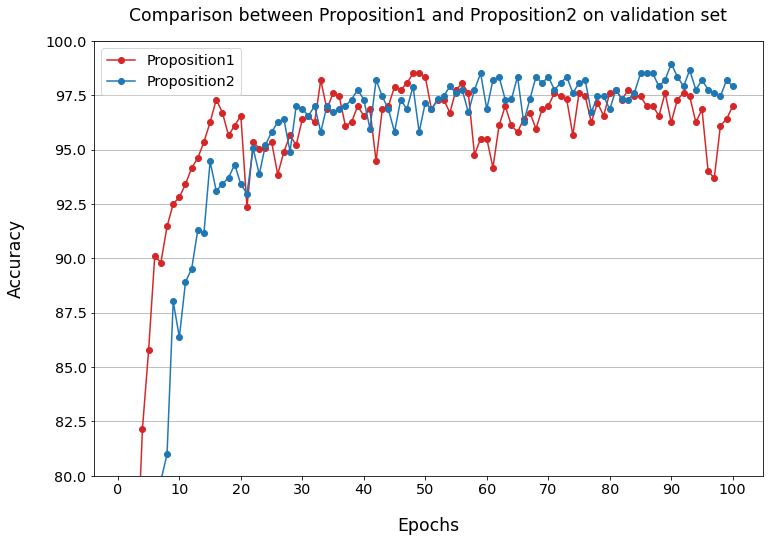

In [ ]:
x = list(range(1, epochs + 1))
y1 = proposition1_val_accuracy.tolist()
y2 = proposition2_val_accuracy.tolist()

plt.figure(figsize=(12, 8))
plt.title('Comparison between Proposition1 and Proposition2 on validation set')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(80, 100)
plt.xticks(np.arange(0, epochs + 1, step=epochs/10, dtype=int))

plt.plot(x, y1, marker='o', label='Proposition1', color='tab:red')
plt.plot(x, y2, marker='o', label='Proposition2', color='tab:blue')
plt.grid(axis='y')
plt.legend(loc=2)
plt.show()

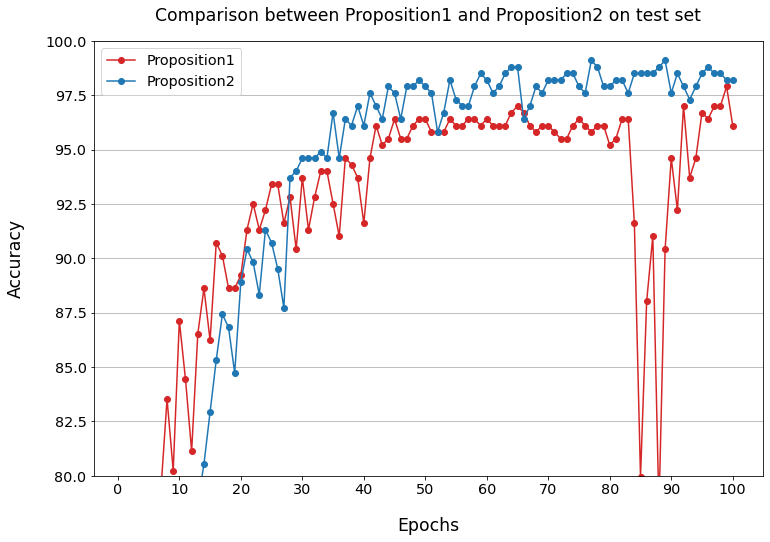

In [ ]:
x = list(range(1, epochs + 1))
y1 = proposition1_test_accuracy.tolist()
y2 = proposition2_test_accuracy.tolist()

plt.figure(figsize=(12, 8))
plt.title('Comparison between Proposition1 and Proposition2 on test set')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(80, 100)
plt.xticks(np.arange(0, epochs + 1, step=epochs/10, dtype=int))

plt.plot(x, y1, marker='o', label='Proposition1', color='tab:red')
plt.plot(x, y2, marker='o', label='Proposition2', color='tab:blue')
plt.grid(axis='y')
plt.legend(loc=2)
plt.show()

In [ ]:
print('Proposition1 validation accuracy: {:.2f}%'.format(max(proposition1_val_accuracy)))
print('Proposition2 validation accuracy: {:.2f}%'.format(max(proposition2_val_accuracy)))
print('')

print('Proposition1 test accuracy: {:.2f}%'.format(max(proposition1_test_accuracy)))
print('Proposition2 test accuracy: {:.2f}%'.format(max(proposition2_test_accuracy)))

Proposition1 validation accuracy: 98.50%
Proposition2 validation accuracy: 98.95%

Proposition1 test accuracy: 97.90%
Proposition2 test accuracy: 99.10%


In [ ]:
learning_rate = 0.001
batch_size = 16
epochs = 200
criterion = nn.NLLLoss()

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
cross_set.dataset = copy.copy(dataset)
cross_set.dataset.transform = transform

In [ ]:
model_val_accuracy = np.zeros(epochs)

for selection, (train_index, val_index) in enumerate(kfold.split(cross_set)):
  model = Modern3()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_set = torch.utils.data.Subset(dataset, train_index)
  val_set = torch.utils.data.Subset(dataset, val_index)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True)

  for epoch in range(epochs):
    loss_value = train_model(model, train_loader, device, criterion, optimizer)
    val_accuracy = eval_model(model, val_loader, device)
    model_val_accuracy[epoch] += val_accuracy

    if epoch % 40 == 39:
      print('Selection {}, Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(selection + 1, epoch + 1, loss_value, val_accuracy))
  
  print('')

proposition1_val_accuracy = np.divide(model_val_accuracy, kfold.n_splits)
print('Proposition1 validation accuracy: {:.2f}%'.format(max(proposition1_val_accuracy)))

Selection 1, Epoch 40, Loss: 0.00, Accuracy: 94.78%
Selection 1, Epoch 80, Loss: 0.00, Accuracy: 98.51%
Selection 1, Epoch 120, Loss: 0.01, Accuracy: 97.01%
Selection 1, Epoch 160, Loss: 0.00, Accuracy: 97.76%
Selection 1, Epoch 200, Loss: 0.00, Accuracy: 99.25%

Selection 2, Epoch 40, Loss: 0.00, Accuracy: 99.25%
Selection 2, Epoch 80, Loss: 0.03, Accuracy: 97.76%
Selection 2, Epoch 120, Loss: 0.00, Accuracy: 99.25%
Selection 2, Epoch 160, Loss: 0.00, Accuracy: 97.76%
Selection 2, Epoch 200, Loss: 0.01, Accuracy: 98.51%

Selection 3, Epoch 40, Loss: 0.14, Accuracy: 96.27%
Selection 3, Epoch 80, Loss: 0.00, Accuracy: 100.00%
Selection 3, Epoch 120, Loss: 0.00, Accuracy: 98.51%
Selection 3, Epoch 160, Loss: 0.00, Accuracy: 97.01%
Selection 3, Epoch 200, Loss: 0.00, Accuracy: 97.01%

Selection 4, Epoch 40, Loss: 0.00, Accuracy: 95.49%
Selection 4, Epoch 80, Loss: 0.00, Accuracy: 96.99%
Selection 4, Epoch 120, Loss: 0.00, Accuracy: 96.99%
Selection 4, Epoch 160, Loss: 0.05, Accuracy: 91.7

In [ ]:
model_test_accuracy = np.zeros(epochs)

model = Modern3()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cross_loader = torch.utils.data.DataLoader(cross_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(epochs):
  loss_value = train_model(model, cross_loader, device, criterion, optimizer)
  test_accuracy = eval_model(model, test_loader, device)
  model_test_accuracy[epoch] = test_accuracy

  if epoch % 40 == 39:
    print('Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(epoch + 1, loss_value, test_accuracy))

print('')

proposition1_test_accuracy = model_test_accuracy
print('Proposition1 test accuracy: {:.2f}%'.format(max(proposition1_test_accuracy)))

Epoch 40, Loss: 0.04, Accuracy: 92.81%
Epoch 80, Loss: 0.02, Accuracy: 94.31%
Epoch 120, Loss: 0.00, Accuracy: 94.91%
Epoch 160, Loss: 0.01, Accuracy: 97.60%
Epoch 200, Loss: 0.00, Accuracy: 95.21%

Proposition1 test accuracy: 97.60%


In [ ]:
transform = transforms.Compose([
  transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
  transforms.RandomAffine(degrees=15),
  transforms.RandomGrayscale(),
  transforms.RandomVerticalFlip(),
  transforms.ToTensor()])

In [ ]:
model_val_accuracy = np.zeros(epochs)

for selection, (train_index, val_index) in enumerate(kfold.split(cross_set)):
  model = Modern3()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_set = torch.utils.data.Subset(dataset, train_index)
  val_set = torch.utils.data.Subset(dataset, val_index)

  train_set.dataset = copy.copy(dataset)
  train_set.dataset.transform = transform

  train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True)

  for epoch in range(epochs):
    loss_value = train_model(model, train_loader, device, criterion, optimizer)
    val_accuracy = eval_model(model, val_loader, device)
    model_val_accuracy[epoch] += val_accuracy

    if epoch % 40 == 39:
      print('Selection {}, Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(selection + 1, epoch + 1, loss_value, val_accuracy))
  
  print('')

proposition2_val_accuracy = np.divide(model_val_accuracy, kfold.n_splits)
print('Proposition2 validation accuracy: {:.2f}%'.format(max(proposition2_val_accuracy)))

Selection 1, Epoch 40, Loss: 0.16, Accuracy: 97.01%
Selection 1, Epoch 80, Loss: 0.13, Accuracy: 97.76%
Selection 1, Epoch 120, Loss: 0.07, Accuracy: 97.76%
Selection 1, Epoch 160, Loss: 0.02, Accuracy: 98.51%
Selection 1, Epoch 200, Loss: 0.15, Accuracy: 96.27%

Selection 2, Epoch 40, Loss: 0.06, Accuracy: 95.52%
Selection 2, Epoch 80, Loss: 0.12, Accuracy: 97.01%
Selection 2, Epoch 120, Loss: 0.08, Accuracy: 98.51%
Selection 2, Epoch 160, Loss: 0.14, Accuracy: 97.01%
Selection 2, Epoch 200, Loss: 0.03, Accuracy: 99.25%

Selection 3, Epoch 40, Loss: 0.18, Accuracy: 92.54%
Selection 3, Epoch 80, Loss: 0.09, Accuracy: 96.27%
Selection 3, Epoch 120, Loss: 0.06, Accuracy: 97.01%
Selection 3, Epoch 160, Loss: 0.09, Accuracy: 98.51%
Selection 3, Epoch 200, Loss: 0.01, Accuracy: 98.51%

Selection 4, Epoch 40, Loss: 0.11, Accuracy: 97.74%
Selection 4, Epoch 80, Loss: 0.09, Accuracy: 94.74%
Selection 4, Epoch 120, Loss: 0.02, Accuracy: 96.24%
Selection 4, Epoch 160, Loss: 0.02, Accuracy: 99.25

In [ ]:
model_test_accuracy = np.zeros(epochs)

model = Modern3()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cross_set.dataset = copy.copy(dataset)
cross_set.dataset.transform = transform

cross_loader = torch.utils.data.DataLoader(cross_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(epochs):
  loss_value = train_model(model, cross_loader, device, criterion, optimizer)
  test_accuracy = eval_model(model, test_loader, device)
  model_test_accuracy[epoch] = test_accuracy

  if epoch % 40 == 39:
    print('Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}%'\
          .format(epoch + 1, loss_value, test_accuracy))

print('')

proposition2_test_accuracy = model_test_accuracy
print('Proposition2 test accuracy: {:.2f}%'.format(max(proposition2_test_accuracy)))

Epoch 40, Loss: 0.16, Accuracy: 96.41%
Epoch 80, Loss: 0.13, Accuracy: 97.60%
Epoch 120, Loss: 0.14, Accuracy: 96.71%
Epoch 160, Loss: 0.10, Accuracy: 97.01%
Epoch 200, Loss: 0.06, Accuracy: 97.60%

Proposition2 test accuracy: 99.70%


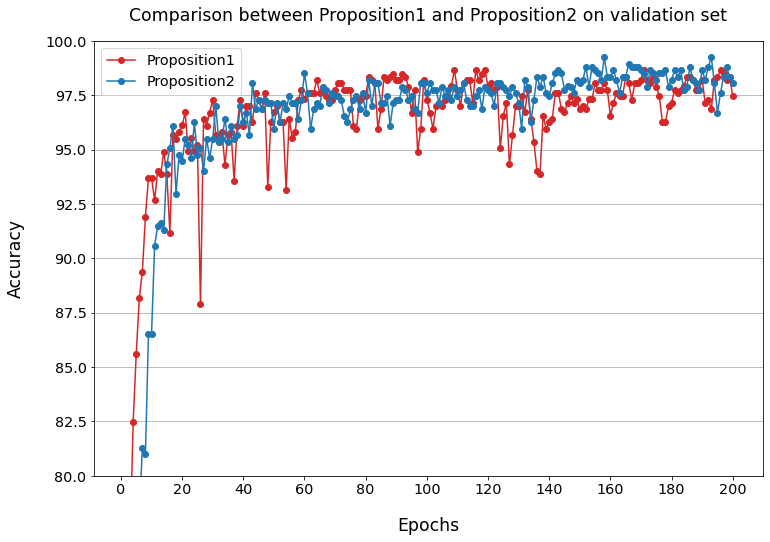

In [ ]:
x = list(range(1, epochs + 1))
y1 = proposition1_val_accuracy.tolist()
y2 = proposition2_val_accuracy.tolist()

plt.figure(figsize=(12, 8))
plt.title('Comparison between Proposition1 and Proposition2 on validation set')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(80, 100)
plt.xticks(np.arange(0, epochs + 1, step=epochs/10, dtype=int))

plt.plot(x, y1, marker='o', label='Proposition1', color='tab:red')
plt.plot(x, y2, marker='o', label='Proposition2', color='tab:blue')
plt.grid(axis='y')
plt.legend(loc=2)
plt.show()

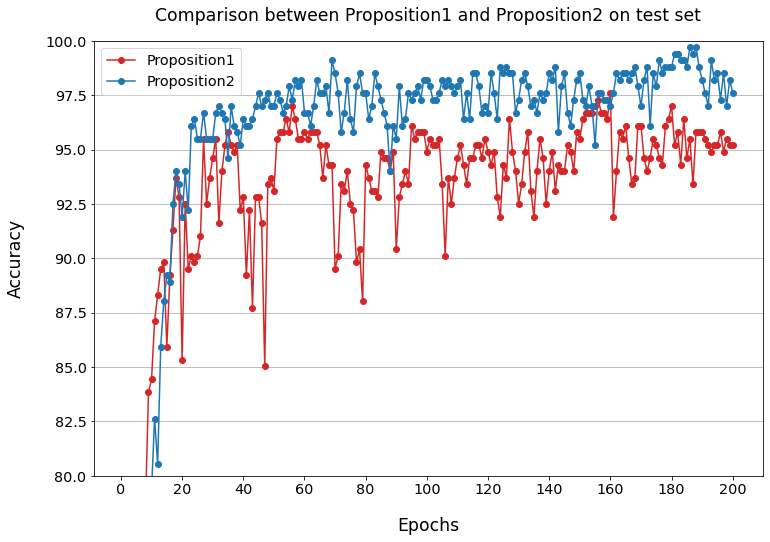

In [ ]:
x = list(range(1, epochs + 1))
y1 = proposition1_test_accuracy.tolist()
y2 = proposition2_test_accuracy.tolist()

plt.figure(figsize=(12, 8))
plt.title('Comparison between Proposition1 and Proposition2 on test set')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(80, 100)
plt.xticks(np.arange(0, epochs + 1, step=epochs/10, dtype=int))

plt.plot(x, y1, marker='o', label='Proposition1', color='tab:red')
plt.plot(x, y2, marker='o', label='Proposition2', color='tab:blue')
plt.grid(axis='y')
plt.legend(loc=2)
plt.show()

In [ ]:
print('Proposition1 validation accuracy: {:.2f}%'.format(max(proposition1_val_accuracy)))
print('Proposition2 validation accuracy: {:.2f}%'.format(max(proposition2_val_accuracy)))
print('')

print('Proposition1 test accuracy: {:.2f}%'.format(max(proposition1_test_accuracy)))
print('Proposition2 test accuracy: {:.2f}%'.format(max(proposition2_test_accuracy)))

Proposition1 validation accuracy: 98.65%
Proposition2 validation accuracy: 99.25%

Proposition1 test accuracy: 97.60%
Proposition2 test accuracy: 99.70%


In [ ]:
model_params = {}

def count_params(model):
  return sum(p.numel() for p in model.parameters())

model_params['Introduction1'] = count_params(Introduction1())
model_params['Introduction2'] = count_params(Introduction2())
model_params['Introduction3'] = count_params(Introduction3())
model_params['Introduction4'] = count_params(Introduction4())

model_params['Modern1'] = count_params(Modern1())
model_params['Modern2'] = count_params(Modern2())
model_params['Modern3'] = count_params(Modern3())

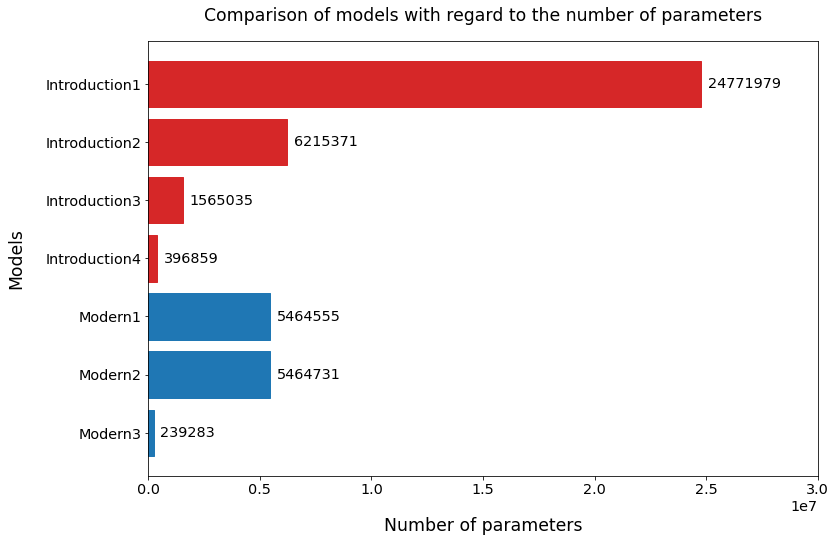

In [ ]:
x = list(model_params.keys())
y = list(model_params.values())

plt.figure(figsize=(12, 8))
plt.title('Comparison of models with regard to the number of parameters')
plt.xlabel('Number of parameters')
plt.ylabel('Models')
plt.xlim(0, 3*10**7)

for i in range(len(x)):
  plt.text(x=y[i] + 3.0*10**5, y=i, s=y[i], va='center', fontsize='x-large')

plot = plt.barh(x, y)

[plot[i].set_color('tab:red') for i in range(0, 4)]
[plot[i].set_color('tab:blue') for i in range(4, 7)]

plt.gca().invert_yaxis()
plt.show()

In [ ]:
print('Introduction1 validation accuracy: {:.2f}%'.format(max(introduction1_val_accuracy)))
print('Introduction2 validation accuracy: {:.2f}%'.format(max(introduction2_val_accuracy)))
print('Introduction3 validation accuracy: {:.2f}%'.format(max(introduction3_val_accuracy)))
print('Introduction4 validation accuracy: {:.2f}%'.format(max(introduction4_val_accuracy)))
print('')

print('Introduction1 test accuracy: {:.2f}%'.format(max(introduction1_test_accuracy)))
print('Introduction2 test accuracy: {:.2f}%'.format(max(introduction2_test_accuracy)))
print('Introduction3 test accuracy: {:.2f}%'.format(max(introduction3_test_accuracy)))
print('Introduction4 test accuracy: {:.2f}%'.format(max(introduction4_test_accuracy)))
print('')

print('Modern1 validation accuracy: {:.2f}%'.format(max(modern1_val_accuracy)))
print('Modern2 validation accuracy: {:.2f}%'.format(max(modern2_val_accuracy)))
print('Modern3 validation accuracy: {:.2f}%'.format(max(modern3_val_accuracy)))
print('')

print('Modern1 test accuracy: {:.2f}%'.format(max(modern1_test_accuracy)))
print('Modern2 test accuracy: {:.2f}%'.format(max(modern2_test_accuracy)))
print('Modern3 test accuracy: {:.2f}%'.format(max(modern3_test_accuracy)))
print('')

print('Proposition1 validation accuracy: {:.2f}%'.format(max(proposition1_val_accuracy)))
print('Proposition2 validation accuracy: {:.2f}%'.format(max(proposition2_val_accuracy)))
print('')

print('Proposition1 test accuracy: {:.2f}%'.format(max(proposition1_test_accuracy)))
print('Proposition2 test accuracy: {:.2f}%'.format(max(proposition2_test_accuracy)))

Introduction1 validation accuracy: 80.53%
Introduction2 validation accuracy: 80.09%
Introduction3 validation accuracy: 82.34%
Introduction4 validation accuracy: 84.89%

Introduction1 test accuracy: 75.75%
Introduction2 test accuracy: 86.53%
Introduction3 test accuracy: 87.13%
Introduction4 test accuracy: 61.98%

Modern1 validation accuracy: 95.36%
Modern2 validation accuracy: 97.30%
Modern3 validation accuracy: 97.46%

Modern1 test accuracy: 91.62%
Modern2 test accuracy: 97.01%
Modern3 test accuracy: 98.20%

Proposition1 validation accuracy: 98.65%
Proposition2 validation accuracy: 99.25%

Proposition1 test accuracy: 97.60%
Proposition2 test accuracy: 99.70%


In [ ]:
model_val_accuracies = {}
model_test_accuracies = {}

model_val_accuracies['Introduction4'] = max(introduction4_val_accuracy)
model_val_accuracies['Introduction1'] = max(introduction1_val_accuracy)
model_val_accuracies['Introduction2'] = max(introduction2_val_accuracy)
model_val_accuracies['Introduction3'] = max(introduction3_val_accuracy)

model_test_accuracies['Introduction4'] = max(introduction4_test_accuracy)
model_test_accuracies['Introduction1'] = max(introduction1_test_accuracy)
model_test_accuracies['Introduction2'] = max(introduction2_test_accuracy)
model_test_accuracies['Introduction3'] = max(introduction3_test_accuracy)

model_val_accuracies['Modern1'] = max(modern1_val_accuracy)
model_val_accuracies['Modern2'] = max(modern2_val_accuracy)
model_val_accuracies['Modern3'] = max(modern3_val_accuracy)

model_test_accuracies['Modern1'] = max(modern1_test_accuracy)
model_test_accuracies['Modern2'] = max(modern2_test_accuracy)
model_test_accuracies['Modern3'] = max(modern3_test_accuracy)

model_val_accuracies['Proposition1'] = max(proposition1_val_accuracy)
model_val_accuracies['Proposition2'] = max(proposition2_val_accuracy)

model_test_accuracies['Proposition1'] = max(proposition1_test_accuracy)
model_test_accuracies['Proposition2'] = max(proposition2_test_accuracy)

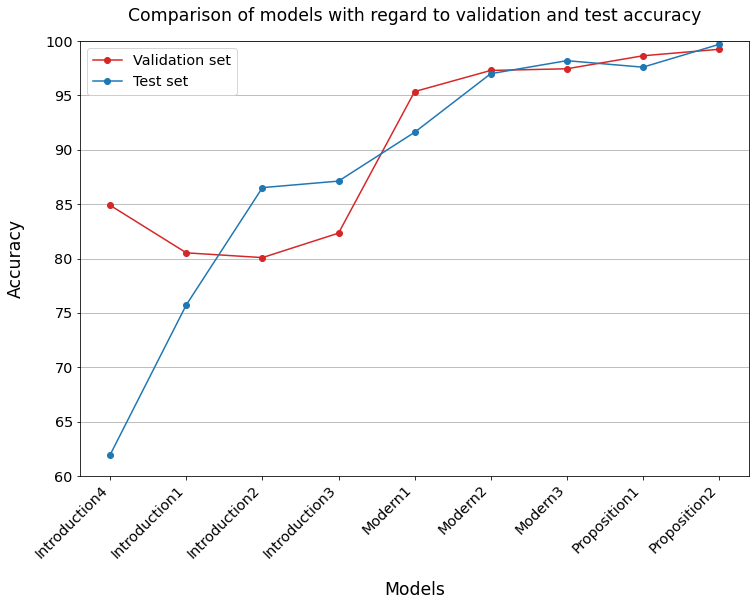

In [ ]:
x = list(model_test_accuracies.keys())
y1 = list(model_val_accuracies.values())
y2 = list(model_test_accuracies.values())

plt.figure(figsize=(12, 8))
plt.title('Comparison of models with regard to validation and test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.ylim(60, 100)
plt.xticks(rotation=45, ha='right')

plt.plot(x, y1, marker='o', label='Validation set', color='tab:red')
plt.plot(x, y2, marker='o', label='Test set', color='tab:blue')
plt.grid(axis='y')
plt.legend(loc=2)
plt.show()